In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit, minimize, differential_evolution
import numpy as np
import os
import re
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt
import statsmodels.api as sm
import joblib as joblib
import Calibration as calibration
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [3]:
dates = [re.findall('\d+', x)[0] for x in os.listdir('sample_data')]

start, end = min(dates), max(dates)
loader = DataLoader("./sample_data", "csv")
df = loader.load_dates(start, end, -1).sort('Date')
df = loader.drop_few_strikes(df)

In [4]:
dates = df['Date'].unique().to_list()
expiries = df.unique(['Date', 'Texp']).select(['Date', 'Texp', 'Expiry']).sort(['Date', 'Texp'])

In [5]:
df

Expiry,Texp,Strike,k,Bid,Ask,Fwd,CallMid,Date,Mid
i64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64
20230816,0.005476,13.5,-0.096873,0.819542,0.89652,14.873224,1.398335,2023-08-14 00:00:00,0.858031
20230816,0.005476,14.0,-0.060505,0.767858,0.84672,14.873224,0.943536,2023-08-14 00:00:00,0.807289
20230816,0.005476,14.5,-0.025414,0.873639,0.948317,14.873224,0.60927,2023-08-14 00:00:00,0.910978
20230816,0.005476,15.0,0.008488,1.003063,1.071872,14.873224,0.396757,2023-08-14 00:00:00,1.037468
20230816,0.005476,16.0,0.073026,1.176715,1.298172,14.873224,0.170756,2023-08-14 00:00:00,1.237444
…,…,…,…,…,…,…,…,…,…
20240522,0.728268,110.0,1.68999,0.899486,0.960186,20.297357,0.213034,2023-08-30 00:00:00,0.929836
20240522,0.728268,120.0,1.777001,0.917649,0.977613,20.297357,0.187055,2023-08-30 00:00:00,0.947631
20240522,0.728268,130.0,1.857044,0.930241,0.996458,20.297357,0.166271,2023-08-30 00:00:00,0.96335


In [6]:
dates[8]

datetime.datetime(2023, 8, 24, 0, 0)

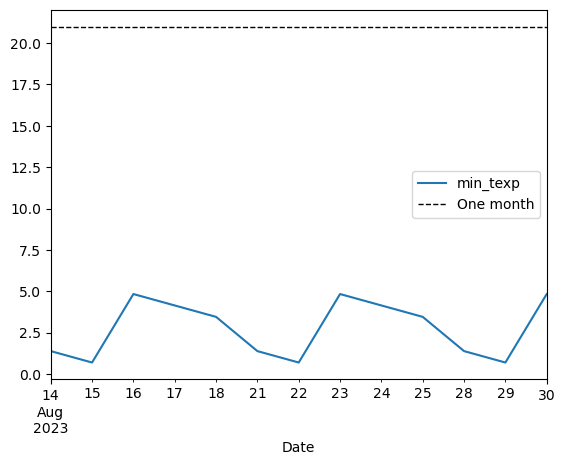

In [7]:
df.group_by('Date').agg(
    min_texp=pl.col('Texp').min() * 252.,
    # max_texp=pl.col('Texp').max() * 252.,
).to_pandas().set_index('Date').plot()
plt.axhline(21., ls='--', lw=1, color='black', label='One month')
plt.legend()
plt.show()

In [8]:
ttm = expiries.filter(
    pl.col('Date') == dates[0]
)['Texp'].to_numpy()

df_day = df.filter(
    pl.col('Date') == dates[0]
)

In [9]:
def plot_smile(df_day, texp, ax):
    sub = df_day.filter(
        pl.col('Texp') == texp
    )[['k', 'Bid', 'Ask', 'Mid']].to_pandas().set_index('k')
    xaxis = np.linspace(sub.index.min(), sub.index.max(), 1000)
    interp = utils.stineman_interp(sub.index.values, sub['Mid'].values, xaxis)
    sub.drop(columns=['Mid']).plot(ax=ax, style=['b^', 'rv'], label=['Bid', 'Ask'])
    ax.plot(xaxis, interp, color='C1', label='Interpolation')
    ax.axvline(0, ls=':', lw=1, color='grey', label='ATM')
    ax.legend(loc='upper left', frameon=True, edgecolor='black')
    ax.set_title(f"Texp {texp*252:.2f} days"); ax.set_xlabel("k"); ax.set_ylabel("Implied vol")

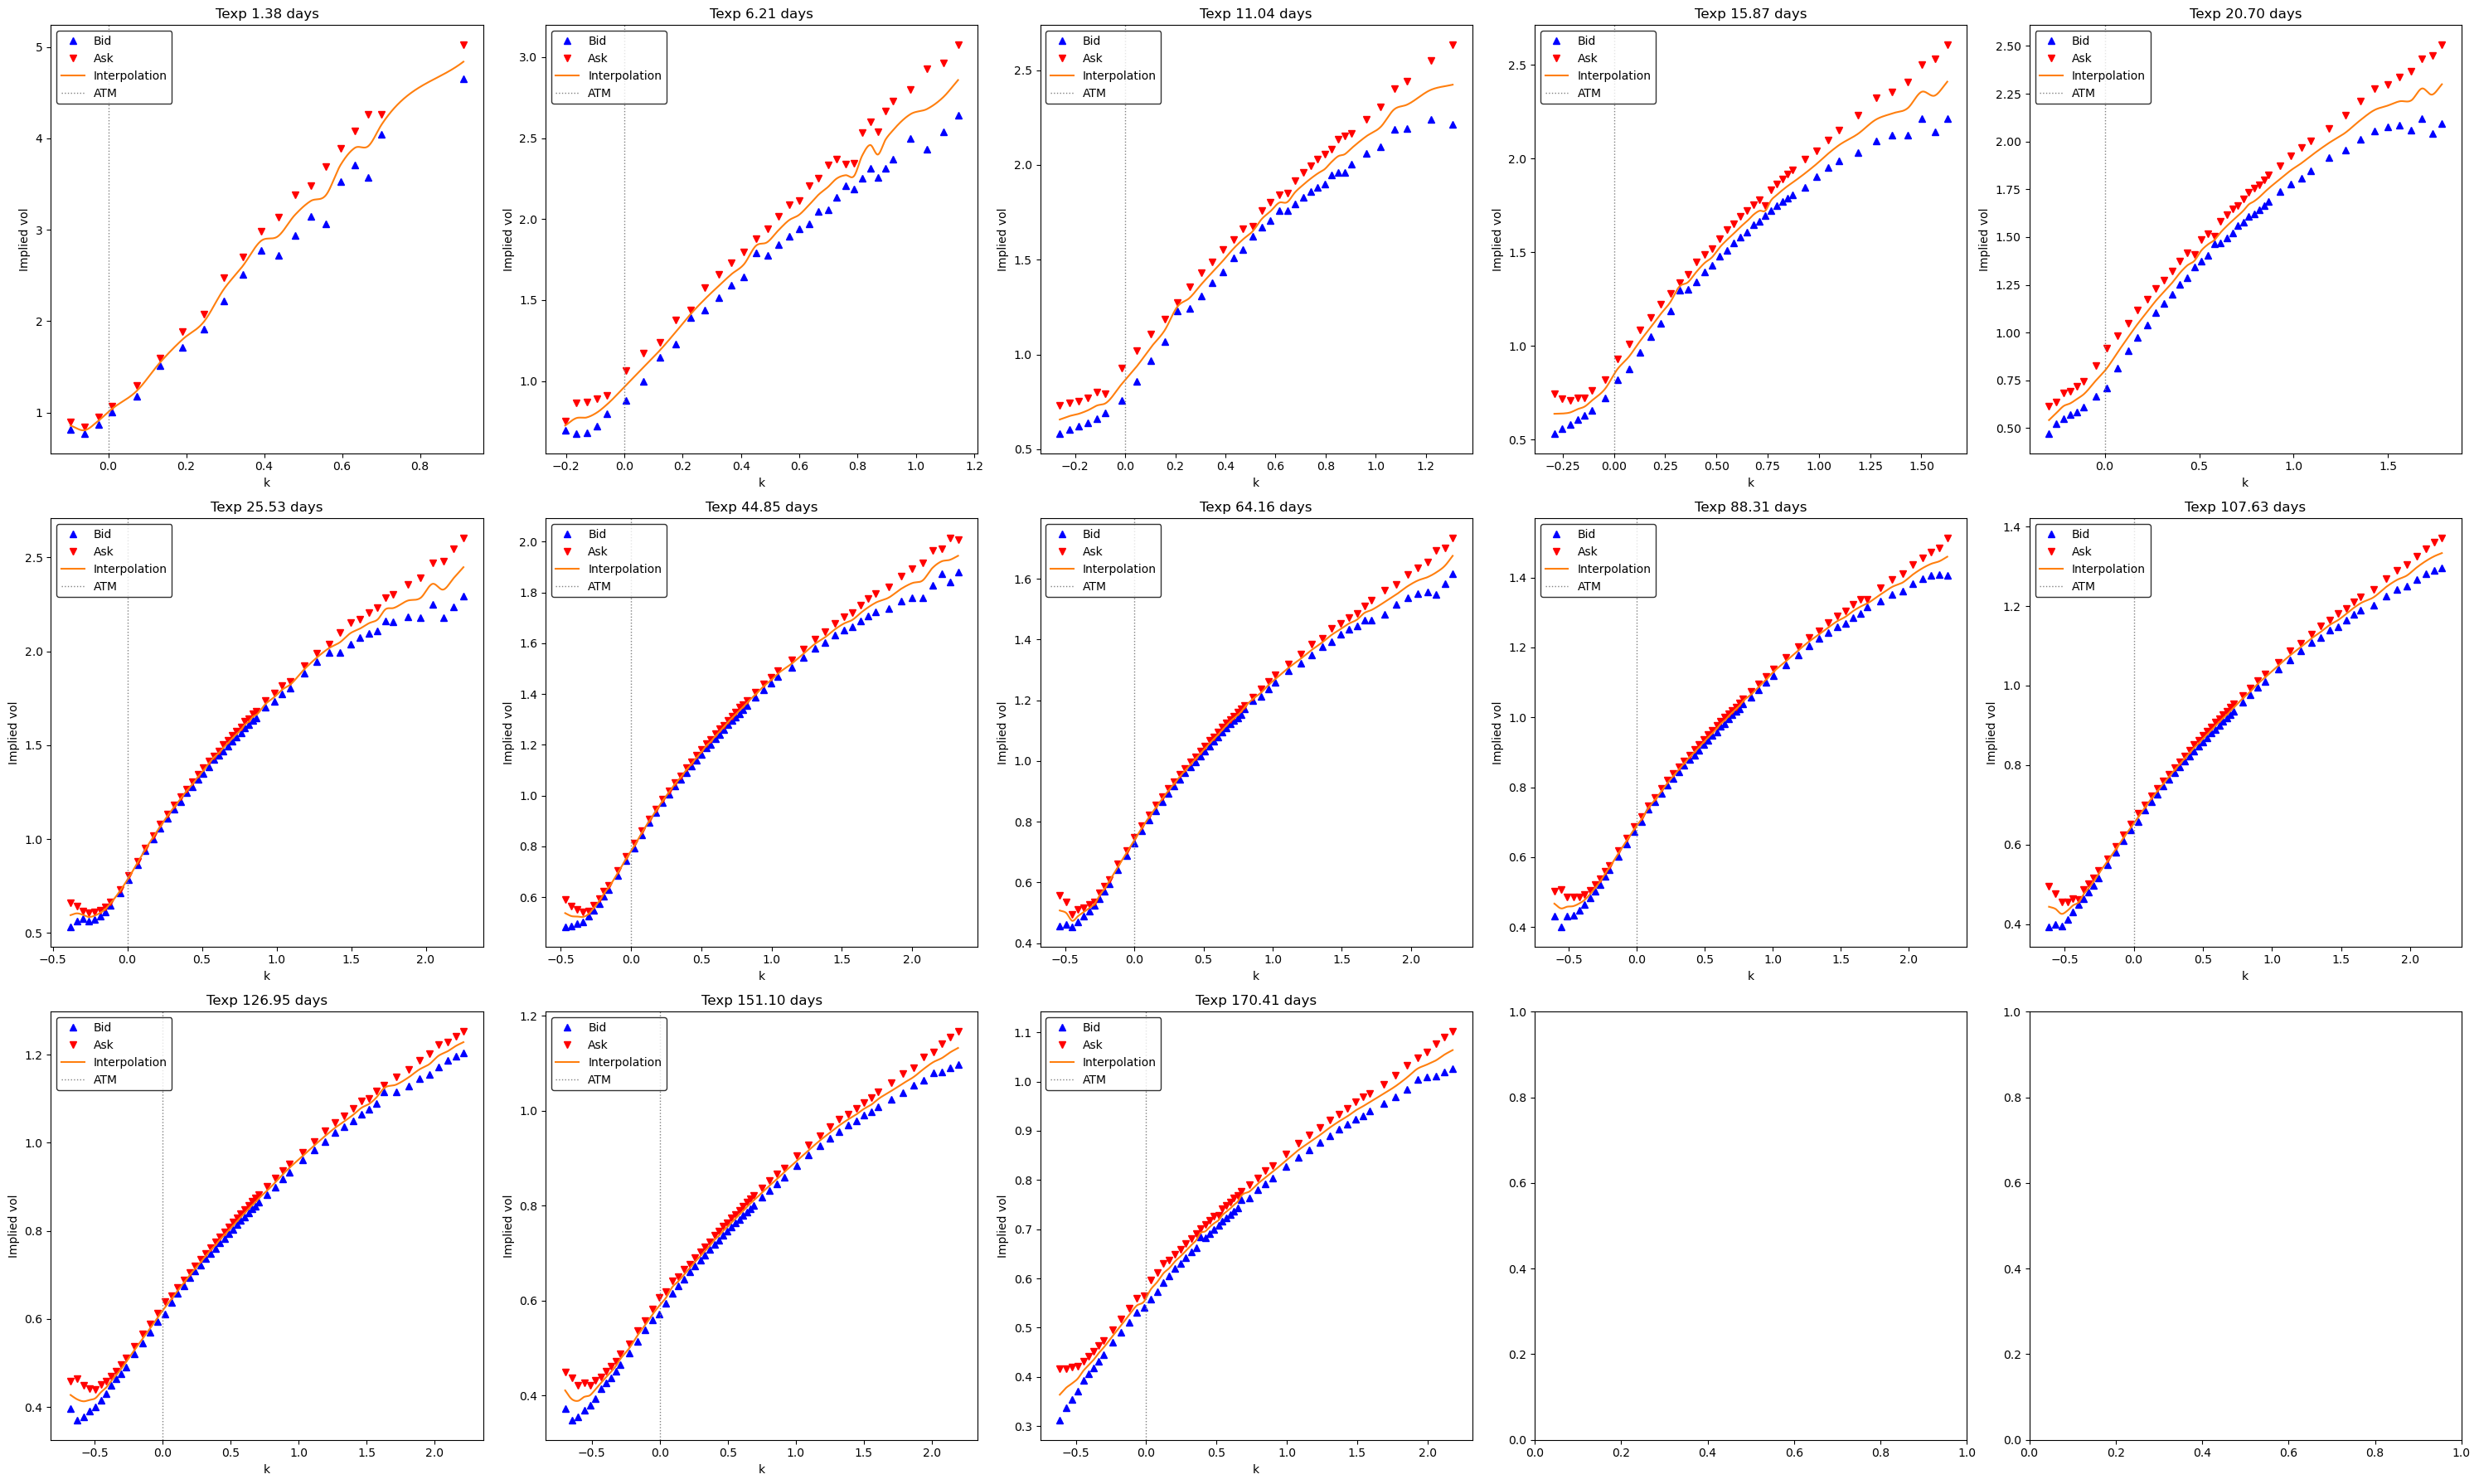

In [10]:
fig, axs = plt.subplots(3, 5, figsize=(30, 18))
axs = axs.flatten()

for i, texp in enumerate(ttm):
    plot_smile(df_day, texp, axs[i])

fig.tight_layout()
plt.show()

In [11]:
def get_skew(df_day: pl.DataFrame, texp: float, eps: float = 1e-2):
    sub = df_day.filter(pl.col('Texp') == texp)
    return np.diff(
        utils.stineman_interp(
            sub['k'].to_numpy(), sub['Mid'].to_numpy(),
            np.array([-eps, eps])
        )
    ).item() / (2 * eps)

In [12]:
skews = np.array([get_skew(df_day, t) for t in ttm])

c, m = sm.OLS(np.log(skews), sm.add_constant(np.log(ttm))).fit().params
paolo = np.exp(c) * np.power(ttm, m)

formula = f"$\mathcal{{S}}(T) = {np.exp(c):.2f}T^{{{m:.2f}}}$"

In [13]:
m + 0.5

0.01947772665195735

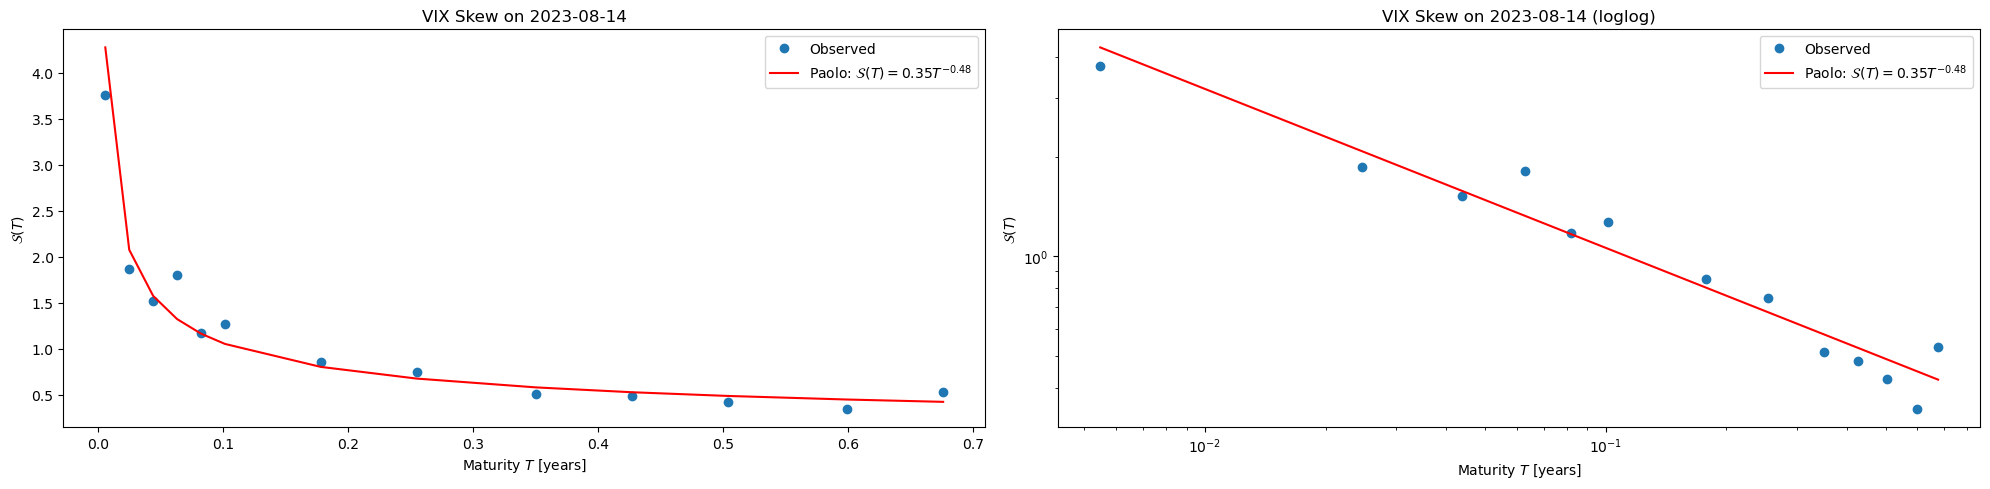

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(ttm, skews, lw=0, marker='o', label='Observed')
axs[0].plot(ttm, paolo, color='red', label='Paolo: ' + formula)

axs[1].loglog(ttm, skews, lw=0, marker='o', label='Observed')
axs[1].loglog(ttm, paolo, color='red', label='Paolo: ' + formula)
for i, ax in enumerate(axs):
    ax.set_ylabel(r"$\mathcal{S}(T)$")
    ax.set_xlabel(r"Maturity $T$ [years]")
    ax.set_title(f"VIX Skew on {dates[0].date()}" + (" (loglog)" * i))
    ax.legend()
fig.tight_layout()
plt.show()

## Play with SVI

In [15]:
def raw_svi(k, a, b, rho, m, sig, texp=1.):
    root = (k-m)**2 + sig**2
    fac = rho * (k - m) + np.sqrt(root)
    return a + b * fac

def svi_jw(k, vt, psi, pw, cw, varmin, texp=1.):
    params = jw_to_svi(texp, vt, psi, cw, pw, varmin)
    return raw_svi(k, *params, texp)

def ssvi(k, theta, phi, rho, *phi_args):
    phi_theta = phi(theta, *phi_args)
    root = (phi_theta * k + rho) + 1 - rho**2
    return 0.5 * theta * (1 + rho*phi_theta*k + np.sqrt(root))

def phi_paolo(theta, eta, gamma):
    return eta / (theta**gamma * (1+theta)**(1-gamma))

def durrelman_svi(k, a, b, rho, m, sig):
    root = (k-m)**2 + sig**2
    w = a + b * (rho * (k - m) + np.sqrt(root))
    dw = b * rho + b * (k - m) / root
    d2w = b * sig**2 / (root ** 3)
    return (1 - 0.5 * k * dw / w) ** 2 - dw**2 / 4 * (1/w + .25) + d2w / 2.

def svi_to_jw(texp, a, b, rho, m, sig):
    root = np.sqrt(m**2 + sig**2)
    
    vt = (a + b * (-rho * m + root)) / texp
    b_hat = np.sqrt(1 / (vt * texp)) * b
    psi = 0.5 * b_hat * (-m / root + rho)
    put_wing = b_hat * (1 - rho)
    call_wing = b_hat * (1 + rho)
    varmin = (a + b * abs(sig) * np.sqrt(1 - rho**2)) / texp
    return vt, psi, put_wing, call_wing, varmin

def jw_to_svi(texp, vt, psi, pw, cw, varmin):
    sqrt_w = np.sqrt(vt * texp)
    b_hat = (pw + cw) / 2.
    b = b_hat * sqrt_w
    rho = 1 - pw / b_hat
    fac1 = (rho - 2 * psi / b_hat)
    fac2 = np.sign(fac1) * np.sqrt(1 / (fac1**2) - 1)
    m = (vt - varmin) * texp / b / (-rho + np.sign(fac2) * np.sqrt(1 + fac2**2) - fac2 + np.sqrt(1 - rho**2))
    sig = fac2 * m
    a = varmin * texp - b * sig * np.sqrt(1 - rho **2)
    return a, b, rho, m, sig

In [16]:
n_mat = np.sum(ttm > 1/12)
n_mat

8

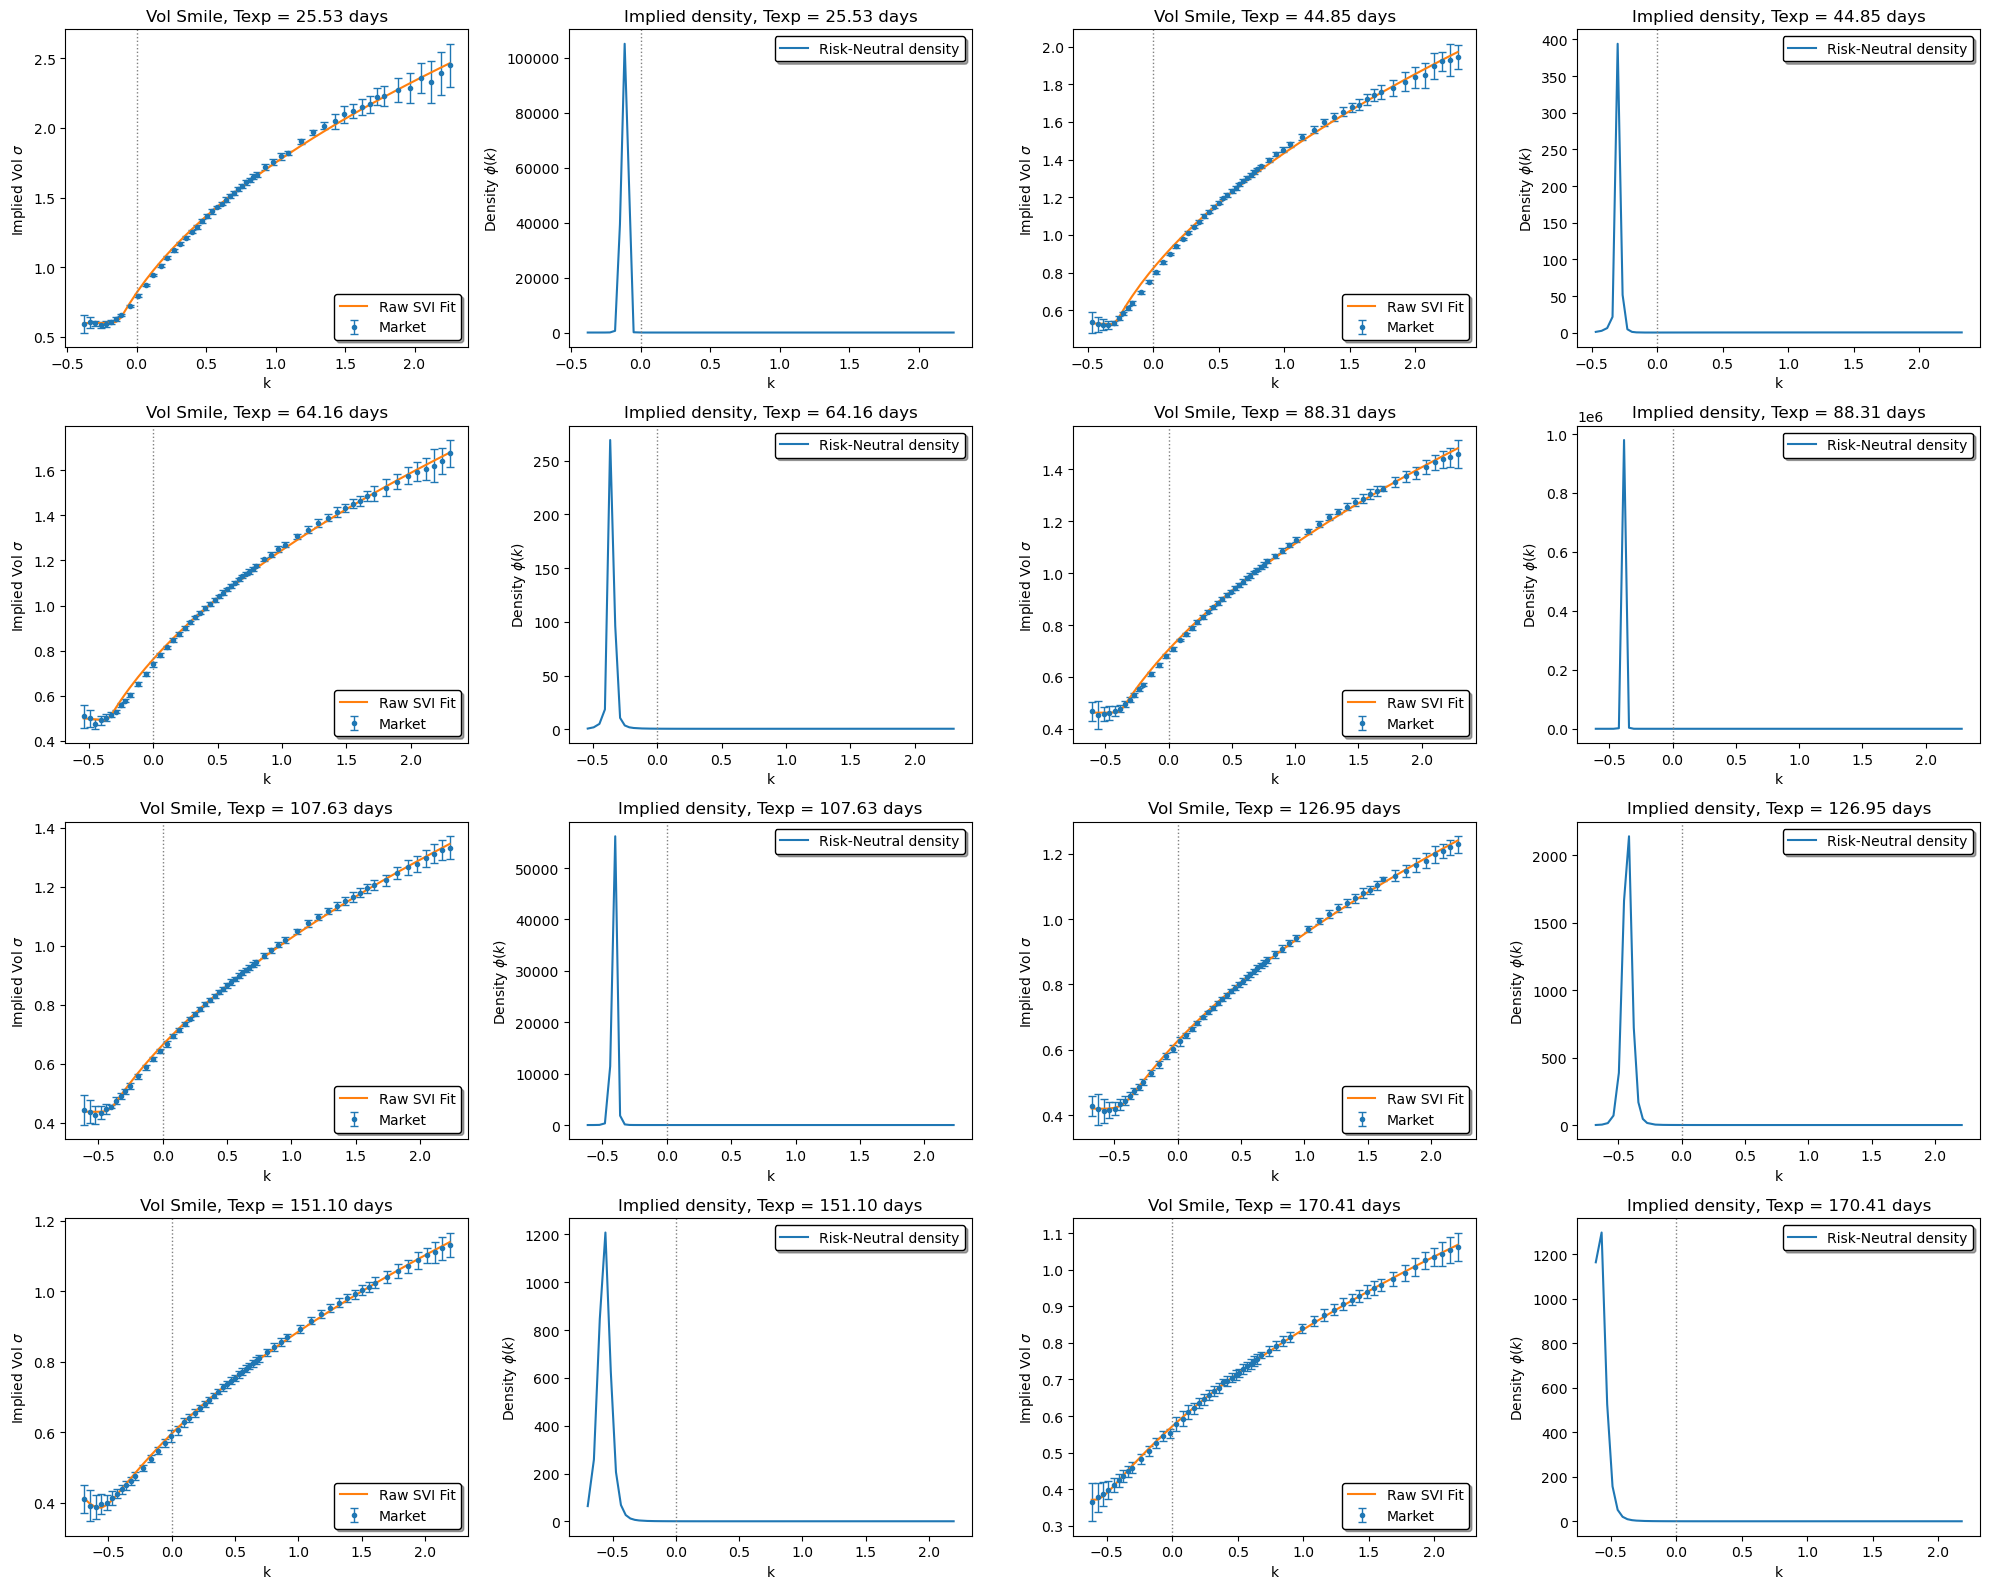

In [18]:
fig, axs = plt.subplots(n_mat // 2, 4, figsize=(20, 4 * n_mat // 2))
axs = axs.flatten()
total_w = {}

for i, texp in enumerate(ttm[ttm > 1/12]):
    sub = df_day.filter(
        pl.col('Texp') == texp
    ).to_pandas().set_index('k')
    k, mids = sub.index.values, sub['Mid'].values

    params, w = calibration.fit_svi(k, mids, texp)
    
    out = sub[['Mid']]
    out['SVI_w'] = w
    total_w[texp] = out

    # sub[['Bid', 'Ask']].plot(ax=axs[0], style=['b^', 'rv'], label=['Bid', 'Ask'])
    axs[2*i].errorbar(k, mids, yerr=[sub['Ask'] - mids, mids - sub['Bid']],
                    capsize=3, markeredgewidth=1, fmt='.', lw=1, label='Market')
    axs[2*i].plot(k, np.sqrt(w / texp), lw=1.5, color='C1', label='Raw SVI Fit')
    axs[2*i].set_ylabel(r"Implied Vol $\sigma$")
    axs[2*i].set_title(f"Vol Smile, Texp = {texp*252:.2f} days")

    g = durrelman_svi(k, *params)
    axs[2*i+1].plot(k, g, label='Risk-Neutral density')
    axs[2*i+1].set_ylabel(r"Density $\phi(k)$")
    axs[2*i+1].set_title(f"Implied density, Texp = {texp*252:.2f} days")

for ax in axs:
    ax.legend(frameon=True, edgecolor='black', shadow=True)
    ax.set_xlabel('k')
    ax.axvline(0, ls=':', lw=1, color='gray')

fig.tight_layout()
plt.show()

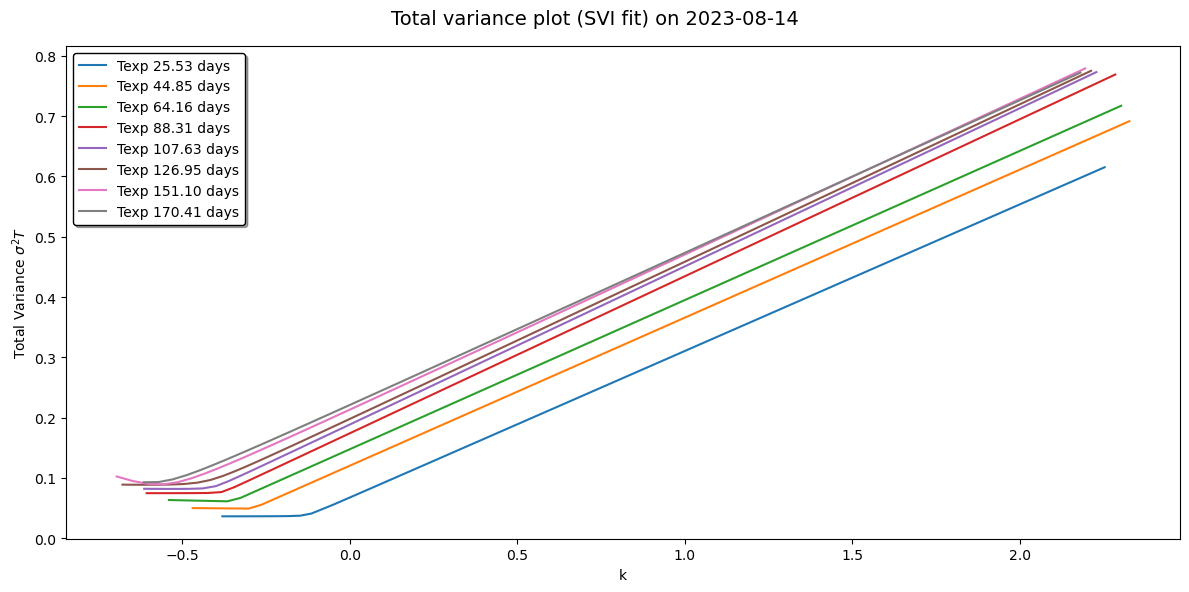

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle(f"Total variance plot (SVI fit) on {dates[0].date()}", fontsize=14)
for i, (texp, w) in enumerate(total_w.items()):
    w['SVI_w'].plot(ax=ax, color=f'C{i}', label=f"Texp {texp*252:.2f} days")
ax.set_xlabel("k"); ax.set_ylabel(r"Total Variance $\sigma^2T$")
ax.legend(edgecolor='black', shadow=True)

fig.tight_layout()
plt.show()